In [1]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

#set directories
workDir = "/Users/czkaiweb/Research/DisappTrksML/VAE/"
saveDir = workDir
dataDir = "/Users/czkaiweb/Research/DisappTrkMLData/converted/"

#load data
df = pd.read_pickle(dataDir+'images_DYJets50_norm_40x40_tanh.pkl')



Using TensorFlow backend.


In [68]:
df_electron_list = df.loc[df['type']==1.0]
df_muon_list     = df.loc[df['type']==2.0]
df_bkg_list      = df.loc[df['type']==0.0]


df_electron = df_electron_list.iloc[:,4:].to_numpy()
df_muon     = df_muon_list.iloc[:,4:].to_numpy()
df_bkg      = df_bkg_list.iloc[:,4:].to_numpy()

print (df_electron.shape[0])
print (df_muon.shape[0])
print (df_bkg.shape[0])

x = df.to_numpy()[:,4:]
y = df.to_numpy()[:,0]

input_train, input_test, target_train,target_test = train_test_split(x, y, test_size=0.30, random_state=42)

input_train = input_train.astype('float32')
input_test = input_test.astype('float32')
target_train = target_train.astype('int64')
target_test = target_test.astype('int64')
print(input_train.shape[0], 'train samples')
print(input_test.shape[0], 'test samples')

2346
8890
5917
12007 train samples
5146 test samples


In [69]:
# Data & model configuration
img_width, img_height = 40,40
num_channels = 4

# Reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)

input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)


input_train = input_train[:,:,:,[3]]
input_test = input_test[:,:,:,[3]]
num_channels = 1
input_shape = (img_height, img_width, num_channels)
input_test.shape


(5146, 40, 40, 1)

In [4]:
print (input_train[:,:,:,:].max())
df.loc[df['4']>1.0]

1.0


,type,deltaRToClosestElectron,deltaRToClosestMuon,deltaRToClosestTau,0,1,2,3,4,5,...,6390,6391,6392,6393,6394,6395,6396,6397,6398,6399


In [ ]:
print (input_train.shape)


In [184]:
# Normalize data
#input_train = input_train / 255
#input_test = input_test / 255

batch_size = 8
no_epochs = 50
validation_split = 0.2
verbosity = 1
latent_dim = 2

# # =================
# # Encoder
# # =================

# Definition
i       = Input(shape=input_shape, name='encoder_input')
cx      = Conv2D(filters=num_channels*4, kernel_size=3, strides=2, padding='same', activation='relu')(i)
#cx      = BatchNormalization()(cx)
#cx      = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
#cx      = BatchNormalization()(cx)
x       = Flatten()(cx)
x       = Dense(20, activation='relu')(x)
#x       = BatchNormalization()(x)
mu      = Dense(latent_dim, name='latent_mu')(x)
sigma   = Dense(latent_dim, name='latent_sigma')(x)

# Get Conv2D shape for Conv2DTranspose operation in decoder
conv_shape = K.int_shape(cx)

# Define sampling with reparameterization trick
def sample_z(args):
    mu, sigma = args
    batch     = K.shape(mu)[0]
    dim       = K.int_shape(mu)[1]
    eps       = K.random_normal(shape=(batch, dim))
    return mu + K.exp(sigma / 2) * eps

# Use reparameterization trick to ....??
z  = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

# Instantiate encoder
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

# =================
# Decoder
# =================

# Definition
d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
#x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(filters=2, kernel_size=3, strides=2, padding='same', activation='relu')(x)
#cx    = BatchNormalization()(cx)
#cx    = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same',  activation='relu')(cx)
#cx    = BatchNormalization()(cx)
#o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)
o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='relu', padding='same', name='decoder_output')(cx)


# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

# =================
# VAE as a whole
# =================

# Instantiate VAE
vae_outputs = decoder(encoder(i)[2])
vae         = Model(i, vae_outputs, name='vae')
vae.summary()


# Define loss
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height * num_channels
    # KL divergence loss
    kl_loss = 1 + sigma  - K.exp(sigma) - K.square(mu)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + 0.001*kl_loss)

# Compile VAE
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)
#vae.compile(optimizer='adadelta', loss=kl_reconstruction_loss)
#vae.compile(optimizer='rmsprop', loss=kl_reconstruction_loss)

# Train autoencoder
history = vae.fit(input_train, input_train, epochs = no_epochs, batch_size = batch_size, validation_split = validation_split)



Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 40, 40, 1)    0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 20, 20, 4)    40          encoder_input[0][0]              
__________________________________________________________________________________________________
flatten_42 (Flatten)            (None, 1600)         0           conv2d_57[0][0]                  
__________________________________________________________________________________________________
dense_83 (Dense)                (None, 20)           32020       flatten_42[0][0]                 
____________________________________________________________________________________________

9605/9605 [==============================] - 6s 656us/step - loss: 11.5433 - val_loss: 12.0656
Epoch 43/50
9605/9605 [==============================] - 6s 652us/step - loss: 11.5610 - val_loss: 12.0244
Epoch 44/50
9605/9605 [==============================] - 7s 695us/step - loss: 11.5153 - val_loss: 12.1202
Epoch 45/50
9605/9605 [==============================] - 7s 745us/step - loss: 11.3964 - val_loss: 12.0689
Epoch 46/50
9605/9605 [==============================] - 7s 716us/step - loss: 11.7318 - val_loss: 12.0325
Epoch 47/50
9605/9605 [==============================] - 7s 699us/step - loss: 11.5895 - val_loss: 11.7396
Epoch 48/50
9605/9605 [==============================] - 7s 716us/step - loss: 11.4515 - val_loss: 11.7095
Epoch 49/50
9605/9605 [==============================] - 7s 732us/step - loss: 11.3276 - val_loss: 11.8081
Epoch 50/50
9605/9605 [==============================] - 7s 709us/step - loss: 11.7802 - val_loss: 11.9192


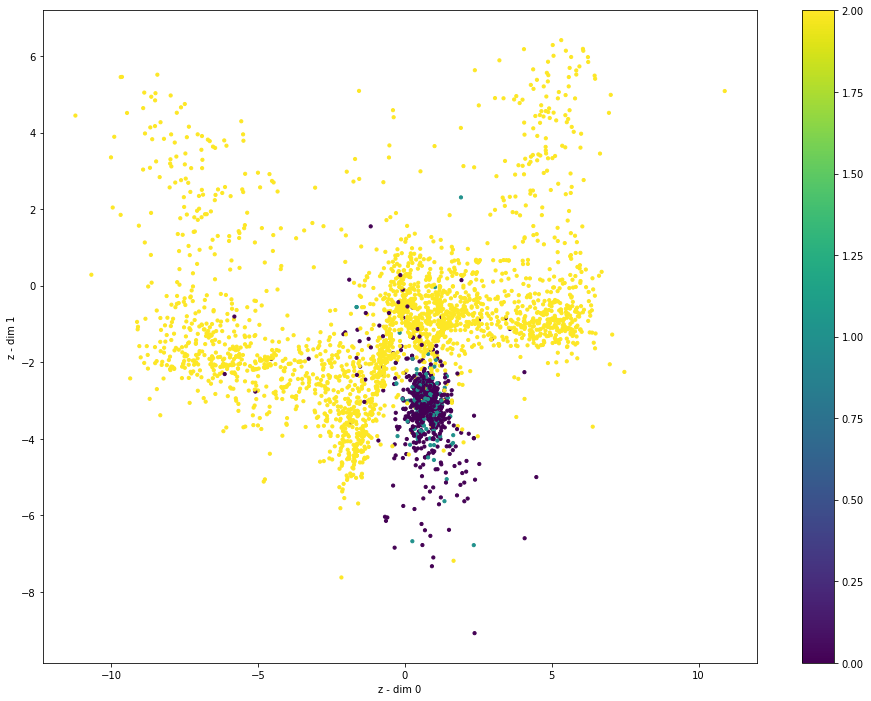

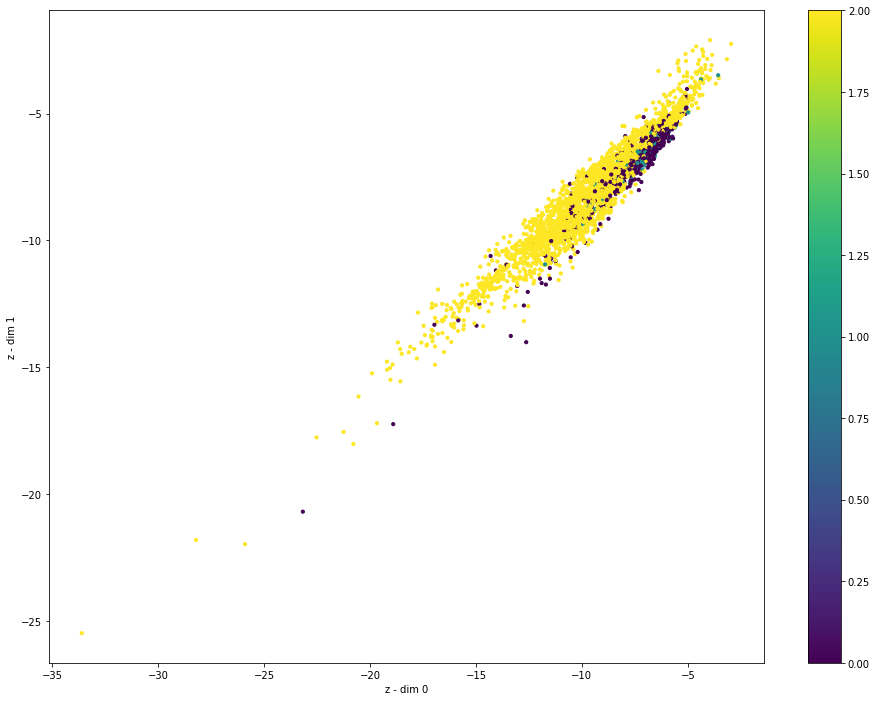

In [185]:
# =================
# Results visualization
# Credits for original visualization code: https://keras.io/examples/variational_autoencoder_deconv/
# (François Chollet).
# Adapted to accomodate this VAE.
# =================

def viz_latent_space(encoder, data, proj_list):
    input_data, target_data = data
    mu, sigma, _ = encoder.predict(input_data)
    plt.figure(figsize=(16, 12))
    plt.scatter(mu[:, proj_list[0]], mu[:, proj_list[1]], c=target_data, s=10)
    plt.xlabel('z - dim '+ str(proj_list[0]))
    plt.ylabel('z - dim '+ str(proj_list[1]))
    plt.colorbar()
    plt.show()
    plt.figure(figsize=(16, 12))
    plt.scatter(sigma[:, proj_list[0]], sigma[:, proj_list[1]], c=target_data, s=10)
    plt.xlabel('z - dim '+ str(proj_list[0]))
    plt.ylabel('z - dim '+ str(proj_list[1]))
    plt.colorbar()
    plt.show()


# Plot results
data = (input_test, target_test)
viz_latent_space(encoder, data,[0,1])
#viz_latent_space(encoder, data,[0,2])
#viz_latent_space(encoder, data,[1,2])

input_test.shape

mu, sigma, _ = encoder.predict(input_test)


In [161]:
def plot_event(x, channel_name):
    
    fig, axs = plt.subplots(1,2,figsize=(10,10))
    
    for i in range(2):
        #axs[i].imshow(x[:,:,i],cmap='Reds_r')
        #axs[i].imshow(x[:,:,i],cmap='coolwarm')
        #axs[i].imshow(x[:,:,i],cmap='Greys')
        axs[i].imshow(x[i][:,:,0])
    
    axs[0].set_title("Input:" + channel_name)
    axs[1].set_title("Output:"+ channel_name)
    #axs[1].set_title("HCAL")
    #axs[2].set_title("CSC - DT - RPC")
    plt.show()






Other:


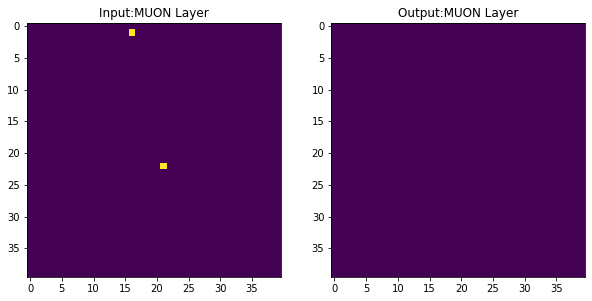

Muon:


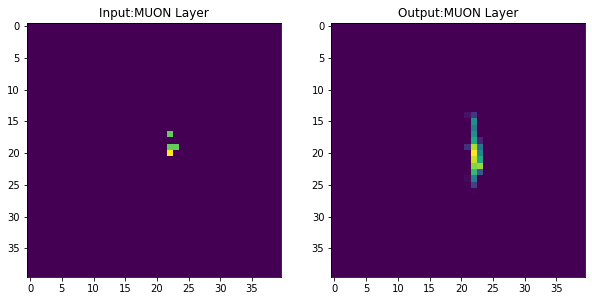

Electron:


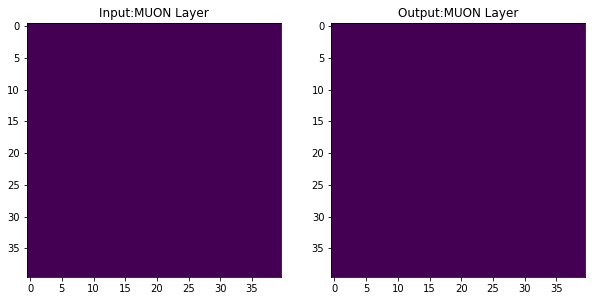

Other:


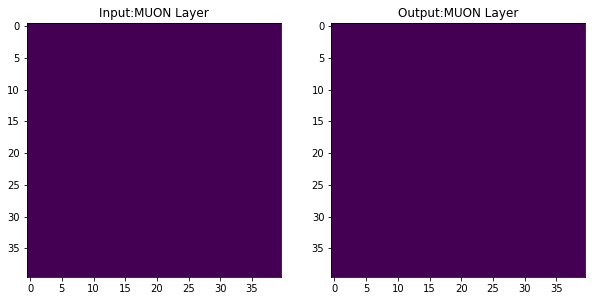

Muon:


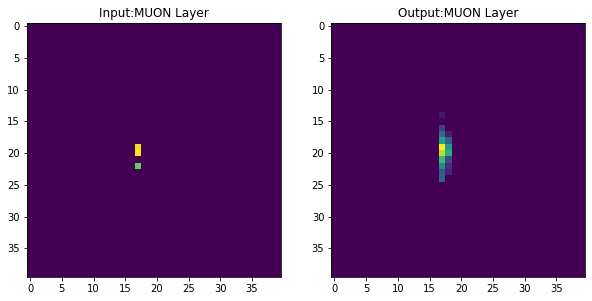

In [186]:
input_plot = input_test
output_plot = vae.predict(input_plot)

#showlist= [1,100,57,532,1012,567]
showlist= [532,67,68,70,71]
Tag = ["Other:","Electron:","Muon:"]
for i in showlist:
    print (Tag[target_test[i]])
    plot_event([input_plot[i],output_plot[i]],"MUON Layer")


In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
plt.show()